## Tuberculosis detection from X-Ray images using Transfer Learning
In this notebook, we will use transfer learning to classify images from the Tuberculosis (TB) Chest X-ray Database dataset. Transfer learning is a technique that allows us to use a pre-trained deep neural network as a starting point for our own model, and then fine-tune the model to our specific task.

The Tuberculosis (TB) Chest X-ray Database consists of chest X-ray images from patients with and without tuberculosis. Our goal is to train a deep learning model that can accurately classify these images as either TB positive or TB negative.

We will use the popular Keras library to implement our deep learning model. Specifically, we will use the VGG16 model as our pre-trained model, and then fine-tune it to our specific task. We will also use data augmentation techniques to increase the size of our training dataset and improve the generalization performance of our model.

By the end of this notebook, we will have a deep learning model that can accurately classify chest X-ray images as either TB positive or TB negative, and we will evaluate the performance of our model using various metrics such as accuracy, precision, recall, and F1 score.

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import pandas as pd
import os

We import the dataset directly from kaggle using its API:

In [3]:
od.download("https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: parhamrou
Your Kaggle Key: ··········


100%|██████████| 663M/663M [00:07<00:00, 87.0MB/s]


Just checking whether our files are read correctly or not:

In [4]:
for dirname, _, filenames in os.walk('./tuberculosis-tb-chest-xray-dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx
./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx
./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/README.md.txt
./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-2844.png
./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-1798.png
./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-2128.png
./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-3241.png
./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-2855.png
./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-1973.png
./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-2764.png
./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-2292.png
./tuberculosis-tb

In [5]:
import pathlib
import numpy as np
data_dir = "./tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/"
data_dir = pathlib.Path(data_dir)
normal = list(data_dir.glob('Normal/*'))
tb = list(data_dir.glob('Tuberculosis/*'))
paths = tb + normal
len(paths)

4200

In reading files, we're first reading the tubor images, and then normal images. So we create a numpy array with 700 leading ones, and then 3500 zeros.

In [6]:
zeros = np.zeros(3500)
ones = np.ones(700)
y = np.concatenate((ones, zeros), axis=0)
y.shape, y[:10]

((4200,), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [7]:
!pip install opencv-python
import cv2

In [8]:
images = []

for path in paths:
  image = cv2.imread(str(path))
  images.append(cv2.resize(image, (224, 224)))

In [9]:
!pip install matplotlib
import matplotlib.image as img

In [10]:
X = np.array(images)
X.shape

(4200, 224, 224, 3)

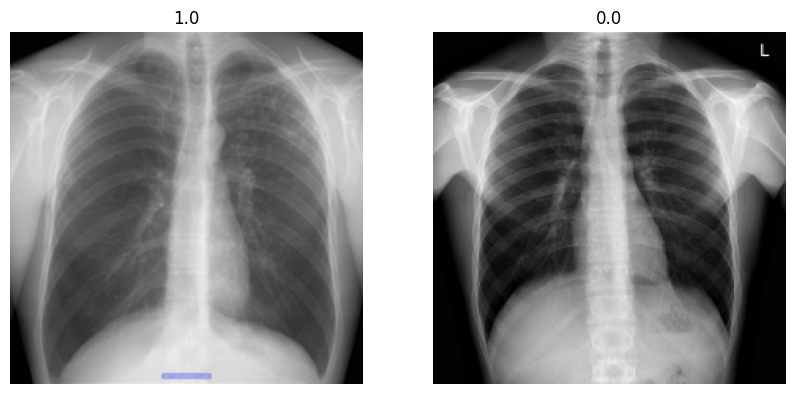

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Show the first image in the first column
axs[0].imshow(X[699])
axs[0].set_title(y[699])

# Show the second image in the second column
axs[1].imshow(X[700])
axs[1].set_title(y[700])

# Hide the axis labels
for ax in axs:
    ax.set_axis_off()

# Display the figure
plt.show()

We have to reshape our training data to a 2 dimensional array to be able to use `RandomOverSampler` method from imblearn:

One of the challenges of working with this dataset is that its classes are not balance, so it will probably lead to overfit our model. We use the OverSamplling method to make the number of samples for each class the same.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=24)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=24)

In [14]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_train.shape

(2520, 150528)

In [15]:
from imblearn.over_sampling import RandomOverSampler

In [16]:
sampler = RandomOverSampler()
X_train, y_train = sampler.fit_resample(X_train, y_train)
X_train = X_train.reshape(-1, 224, 224, 3)

In [17]:
X_train.shape

(4212, 224, 224, 3)

In [18]:
np.sum(y_train == 0), np.sum(y_train == 1)

(2106, 2106)

In [19]:
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications import VGG16
from keras.callbacks import EarlyStopping

## Model selection
For our model, We selected the **VGG16** model with weights of the **imagenet** dataset, and added first a Dense layer with 112 neurons with Relu activaition function, and then another Dense layer with just one unit. Notice that we're using the linear activation function for this layer instead of using sigmoid function for the effiency. We will later use the tensorflow sigmoid function to get the probabilities and classifying our test data.

In [20]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# We just want to train the last layers, so:
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(112, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(56, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=0.02))

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=4,
    restore_best_weights=True,
)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])

58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/10
132/132 [==============================] - 3100s 23s/step - loss: 14.6994 - val_loss: 0.1969
Epoch 2/10
132/132 [==============================] - 3096s 23s/step - loss: 0.3893 - val_loss: 0.0958
Epoch 3/10
132/132 [==============================] - 3100s 24s/step - loss: 0.1655 - val_loss: 0.0581
Epoch 4/10
132/132 [==============================] - 3098s 24s/step - loss: 0.0965 - val_loss: 0.0449
Epoch 5/10
132/132 [==============================] - 3091s 23s/step - loss: 0.1292 - val_loss: 0.0711
Epoch 6/10
132/132 [==============================] - 3094s 23s/step - loss: 0.2592 - val_loss: 0.0969
Epoch 7/10
132/132 [==============================] - 3094s 23s/step - loss: 0.4509 - val_loss: 0.2323
Epoch 8/10
132/132 [==============================] - 3031s 23s/step - loss: 0.1976 - val_loss: 0.1045


## Learning curves
We're plotting learning curves during our training process to make sure that our model is not overfitted to the training data:

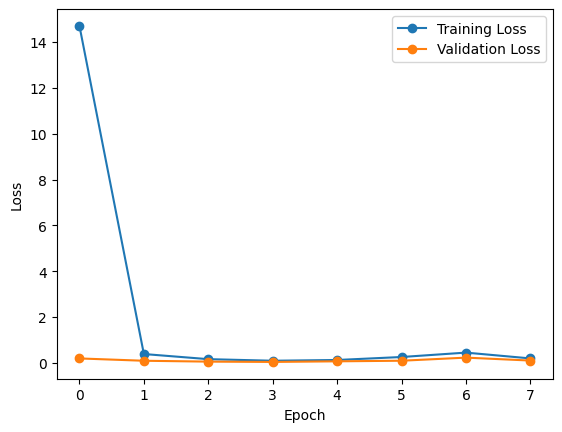

In [23]:
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Learning Curves after the first epoch
Just to have a more datailed plots:

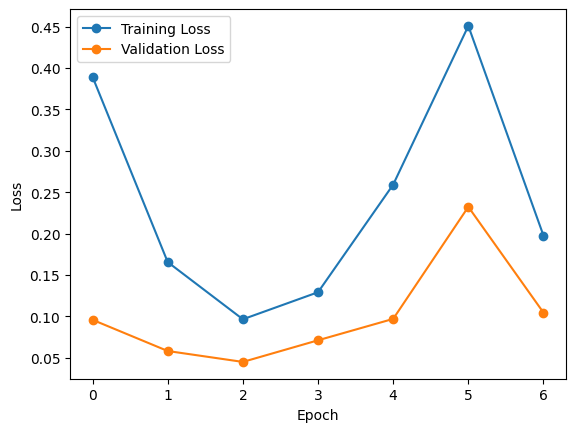

In [24]:
plt.plot(history.history['loss'][1:], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'][1:], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predicting

We predict our test data with our model. Notice that the output of the predict method is the number that we have to pass to the sigmoid function to get the probabilites, since we haven't used sigmoid function directly in the last layer of the model.

In [25]:
predicts = model.predict(X_test)
predict_probs = tf.nn.sigmoid(predicts)
predict_probs[:10].numpy(), y_test[:10]

27/27 [==============================] - 508s 19s/step


(array([[9.9829489e-01],
        [1.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [1.7330641e-14],
        [4.8733892e-07],
        [1.2439857e-27],
        [3.1951163e-06],
        [0.0000000e+00],
        [1.3747108e-18]], dtype=float32),
 array([1., 1., 0., 0., 0., 0., 0., 1., 0., 0.]))

We set the treshold to 0.5, and classify the test data using our model:

In [26]:
y_pred = (predict_probs.numpy() >= 0.5).astype(int)
y_pred[:10]

array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

## Model Evaluation
Now we have to check difference metrics for our model to make sure that it has a good accuracy in classifying unseen data:

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

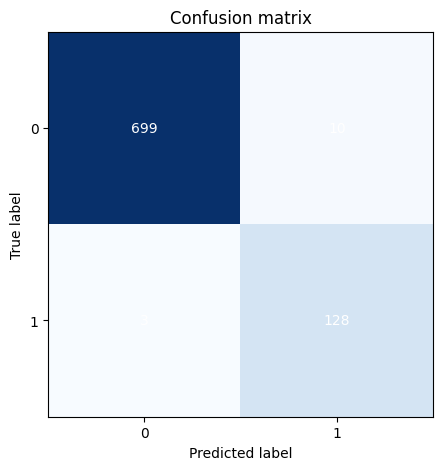

In [28]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Confusion matrix')
ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(['0', '1'])
ax.set_yticklabels(['0', '1'])
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

In [29]:
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred))

Accuracy score:  0.9845238095238096
Recall score:  0.9770992366412213
Precision score:  0.927536231884058
F1 score:  0.9516728624535316


In [30]:
model.save('my_model.h5')